In [34]:
def load_data(company, location):
    !pip3 install import_ipynb
    import import_ipynb
    from T3resampling import Reader
    # Loading data
    loc = 'trips.csv'
    dat = Reader(loc)
    # Show statistics
    dat.showStats()
    # Select only subset of companies and areas to reduce computation load
    dat.createSubset(company,location)
    # Number of company-pickups
    dat.showSubsetStats()
    # Save into a simplified trip record
    loc = 'trips_simpler.csv'
    dat.save(loc)

company = [2,3,4,5]
location = [mk for mk in range(9)]
#load_data(company,location)

In [35]:
import pandas as pd
from numpy import array
import matplotlib.pyplot as pl
from random import randrange

In [36]:
def getSample(inp,pred,outp,samples=1):
    sample = []
    for i in range(samples):
        rnd = randrange(len(pred))
        sample.append(list([inp[rnd],pred[rnd],outp[rnd]]))
    return sample

def unnegate(num):
    if num < 0:
        num = 0
    return num

# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
def reshapeData(dat):
    dat = array(dat)
    dat = dat.reshape((dat.shape[0], 1, dat.shape[1], 1))
    print(dat.shape)
    return dat

def binToWindows(bin_string):
    day = 86400
    divider = 1
    if bin_string[-1] == 'T':
        divider *= 60 * int(bin_string[:-1])
    elif bin_string[-1] == 'H':
        divider *= 3600 * int(bin_string[:-1])
    return int(day/divider)

def flatten(lst):
    l = []
    for e in lst:
        if type(e) == list:
            for k in e:
                if type(k) == list:
                    for b in k:
                        if type(b) == list:
                            l.append(b[0])
                        else:
                            l.append(b)
                else:
                    l.append(k)
        else:
            l.append(e)
    return l

In [37]:
class DataPrep:
    def __init__(self,dat,company,location,bin_,frame_out, ratio):
        self.dat = pd.read_csv(dat)
        self.company = company
        self.location = location
        self.bin_ = bin_
        self.bin_out = None
        self.bin_out_test = None
        self.frame_in = binToWindows(self.bin_)
        self.frame_out = frame_out
        self.inp_train = None
        self.outp_train = None
        self.inp_test = None
        self.outp_test = None
        self.ratio = ratio
    
    def binning(self, dat):
        # Convert the data to (0) per-two-hour (1) per-hour, (2) per-30-minute, (3) per-15-minute bin
        # ONLY on pickup
        dat['pickup_datetime'] = pd.to_datetime(dat['pickup_datetime'])
        dat = dat.set_index(['pickup_datetime'])
        dat = dat['n']

        bin_out = {}
        bin_out = dat.resample(self.bin_).count()
        return bin_out

    def set_test_criteria(self, company, location):
        # Modify test cases
        if len(company) != 0:
            dat_limited = self.dat[self.dat['hvfhs_license_num'].isin(company)]
        if len(location) != 0:
            dat_limited = self.dat[self.dat['PULocationID'].isin(location)]
        self.bin_out_test = self.binning(dat_limited)

    def separate_in_out(self, dat):
        d = []
        idx = -self.frame_in + 1
        for i in range(len(dat)):
            dj = []
            dk = []
            for j in range(self.frame_in):
                dj.append(dat[unnegate(idx + j)])
            for k in range(self.frame_out):
                try:
                    dk.append(dat[unnegate(idx + self.frame_in + k)])
                except:
                    break
            d.append([dj,dk])
            idx += 1
        result = pd.DataFrame(d[self.frame_in:-self.frame_out], columns=['inp','outp'])
        inp = result['inp'].tolist()
        outp = result['outp'].tolist()
        return inp, outp

    def buildTrainingData(self): # e.g. window = 5, step = 2: [1 2 3 4 5] -> 6 7
        inp, outp = self.separate_in_out(self.bin_out)
        self.inp_train = reshapeData(inp[:int(len(inp)*self.ratio)])
        self.out_train = array(outp[:int(len(outp)*self.ratio)])

        inp_t,out_t = self.separate_in_out(self.bin_out_test)
        self.inp_test = reshapeData(inp_t[int(len(inp_t)*self.ratio):])
        self.out_test = array(out_t[int(len(out_t)*self.ratio):])

    def summary(self):
        sum_dtl = sum(self.inp_train) + sum(self.inp_test)
        sum_tet = sum(self.inp_test)
        print("Sum of all datalist: " + str(sum_dtl[0][0][0]))
        print("Sum of all tested: " + str(sum_tet[0][0][0]))

    def setup(self):
        self.bin_out = self.binning(self.dat)
        self.buildTrainingData()
        self.summary()

    def extract(self):
        return self.inp_train, self.out_train, self.inp_test, self.out_test

In [38]:
# Builder
dat = 'trips_simpler.csv'
bin_ = '40T'
company_test = [2,3,4,5]
location_test = [mk for mk in range(9)]
frame_in = binToWindows(bin_)
frame_out = 2
ratio = 0.8

tr = DataPrep(dat,company,location,bin_,frame_out,ratio)
tr.set_test_criteria(company_test,location_test)
tr.setup()

inp_train, out_train, inp_test, out_test = tr.extract()

(833, 1, 36, 1)
(209, 1, 36, 1)
Sum of all datalist: [18381843]
Sum of all tested: [3928467]


In [40]:
# ML part
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from keras.callbacks import History
from sklearn.metrics import mean_squared_error

In [41]:
class CNNLSTM:
    def __init__(self, dat_in, dat_out, frame_in, frame_out, filters_=128, kernel_size_=5, pool_size_=4, epochs = 750):
        self.model = Sequential()
        self.model.add(TimeDistributed(Conv1D(filters=filters_, kernel_size=kernel_size_, activation='relu'), input_shape=(None, frame_in, 1)))
        self.model.add(TimeDistributed(MaxPooling1D(pool_size=pool_size_)))
        self.model.add(TimeDistributed(Flatten()))
        self.model.add(LSTM(200, activation='relu'))
        self.model.add(Dense(frame_out))
        self.model.compile(optimizer='adam', loss='mse')
        self.history = History()
        self.dat_in = dat_in
        self.dat_out = dat_out
        self.epochs = epochs

    def summary(self):
        return self.model.summary()

    def extract(self):
        return self.model

    def train(self, new_dat_in=None, new_dat_out=None):
        if new_dat_in == None or new_dat_out == None:
            self.model.fit(self.dat_in, self.dat_out, epochs=self.epochs, verbose=0, shuffle=True, callbacks=[self.history])
        else:
            self.model.fit(new_dat_in, new_dat_out, epochs=self.epochs, verbose=0, shuffle=True, callbacks=[self.history])

    def drawLoss(self):
        from numpy import log
        loss = self.history.history['loss']
        loss_f, loss_ax = pl.subplots()
        loss_ax.set_yscale("log")
        loss_ax.plot(loss)

In [50]:
model_1 = CNNLSTM(inp_train, array(out_train), frame_in, frame_out)
model_1.train()

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


2021-08-05 04:41:40.123623: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-05 04:41:40.141452: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2592000000 Hz


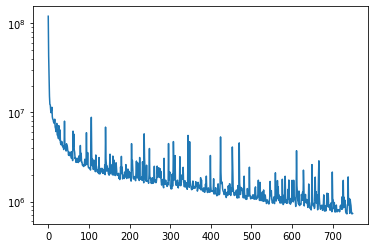

In [51]:
model_1.drawLoss()

In [57]:
class Prediction:
    def __init__(self, inp, outp, model, frame_in):
        self.inp = inp
        self.model = model
        self.outp = outp
        self.pred = []
        self.frame_in = frame_in
        self.rmse = None

    def predict(self):
        for to_test_idx in range(len(self.inp)):
            x_input = self.inp[to_test_idx]
            x_input = x_input.reshape((1, 1, self.frame_in, 1))
            yhat = self.model.model.predict(x_input, verbose=0)
            self.pred.append(yhat.tolist()[0])
        self.rmse = (mean_squared_error(self.pred, self.outp) / frame_out) ** 0.5

    def summary(self, label=""):
        sum_dat = 0
        len_dat = 0
        for i in self.inp:
            for j in i:
                sum_dat += j[0]
                len_dat += 1
        average_bin_value = sum_dat/len_dat
        in_percent = self.rmse/average_bin_value*10000//1/100

        print("RMSE " + label + " = " + str(int(self.rmse)))
        print("Total demand " + label + " = " + str(sum_dat))
        print("Average demand " + label + " = " + str(int(average_bin_value)))
        print("Deviation " + label + " = " + str(in_percent) + "%")
    
    def extract(self):
        return self.pred
        

In [59]:
pred_train = Prediction(inp_train, out_train, model_1, frame_in)
pred_train.predict()
pred_train.summary("train")
pred_train_out = pred_train.extract()

pred_test = Prediction(inp_test, out_test, model_1, frame_in)
pred_test.predict()
pred_test.summary("test")
pred_test_out = pred_test.extract()

RMSE train = 593
Total demand train = [14453376]
Average demand train = 17350
Deviation train = [3.41]%
RMSE test = 701
Total demand test = [3928467]
Average demand test = 18796
Deviation test = [3.73]%


In [60]:
from math import ceil
def visualize(samples,width=2):
    fig, axs = pl.subplots(ceil(len(samples)/2),width)
    fig.set_size_inches(26,2 * len(samples))
    idxy, idxx = 0, 0
    idx = idxy * width + idxx
    fig.suptitle('Random ' + str(len(samples)) + ' Prediction Samples of window = ' + str(frame_in) + ',  timeframe = ' + str(frame_out))
    while idx < len(samples):
        while idxx < width:
            try:
                actual = samples[idx][0].tolist()
                actual = flatten(actual)
                len_init = len(actual)
                actual.append(flatten(samples[idx][2]))
                actual = flatten(actual)
                predicted = flatten(samples[idx][1])
                idx_a = [x for x in range(len(actual))]
                idx_p = [x for x in range(len_init,len_init+len(predicted))]
                axs[idxy, idxx].plot(idx_a, actual)
                axs[idxy, idxx].plot(idx_p, predicted, '--')
                idxx += 1
                idx += 1
            except IndexError:
                break
        idxx = 0
        idxy += 1
    for ax in axs.flat:
        ax.set(xlabel='time', ylabel='demand')
        ax.label_outer()

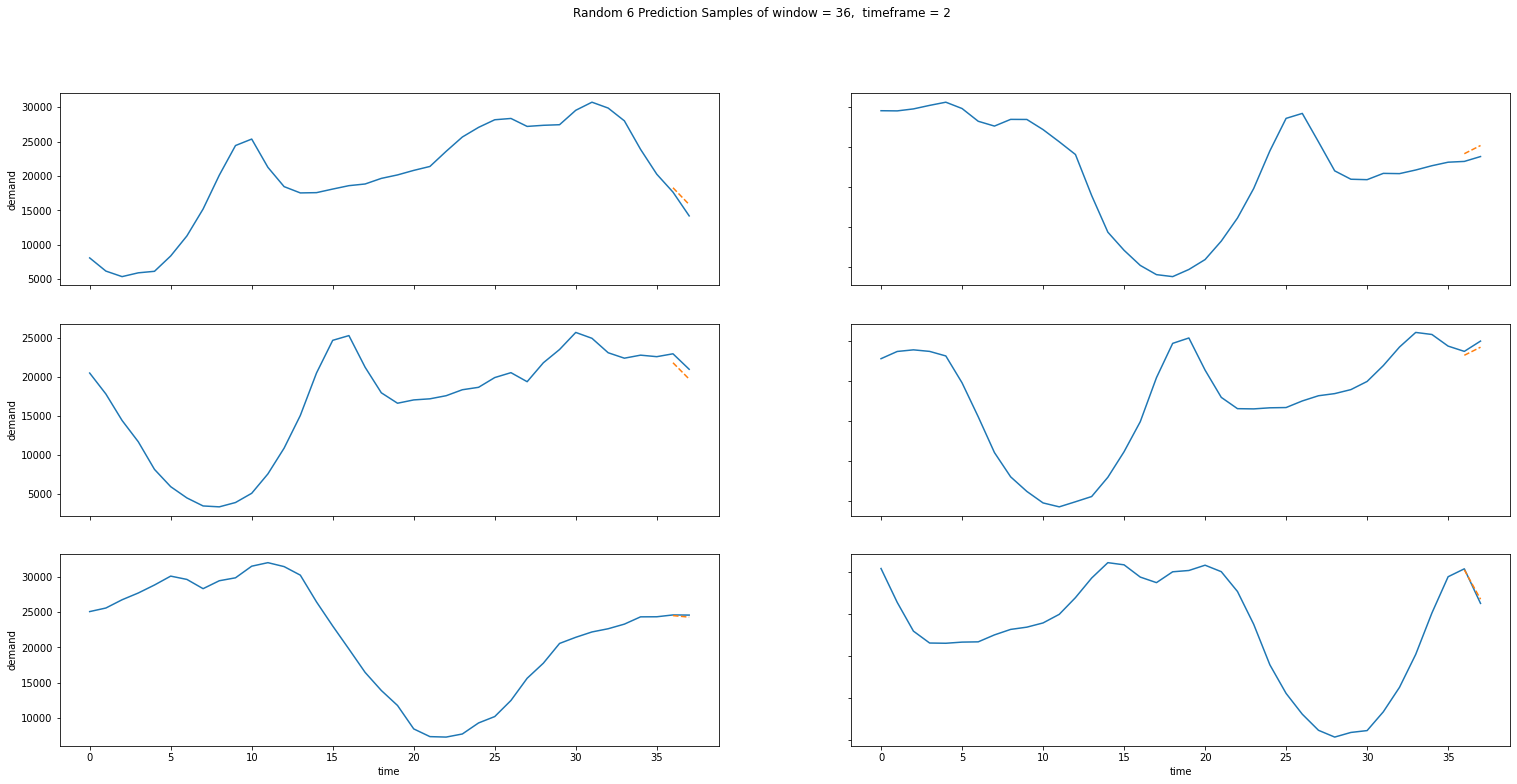

In [64]:
samp_test = getSample(inp_test,pred_test_out,out_test,samples=6)
visualize(samp_test)